In [1]:
import cv2 as cv
import PIL
import os
os.environ["OMP_NUM_THREADS"] = "3"
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image
import glob
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
import timm
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,BisectingKMeans,SpectralClustering,DBSCAN,AgglomerativeClustering
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import silhouette_score

# Feature extraction
dog_images = glob.glob('./cropped100_dogs/*/*')
new_path='./cropped224_dogs'
os.makedirs(new_path, exist_ok=True)
count=0
imgs_n = []
true_labels=[]
for file in dog_images:
    new_path='./cropped224_dogs'
    img = Image.open(file)
    img2 = img.resize((224, 224), PIL.Image.LANCZOS)
    base_name = os.path.basename(file)
    new_path = os.path.join(new_path, base_name)
    img2.save(new_path)
    image_dog=cv.imread(new_path,1)
    imgn = cv.normalize(image_dog, None, 0, 255, cv.NORM_MINMAX)
    imgn = np.transpose(imgn, (2, 0, 1))
    imgs_n.append(imgn)
    if "n02099712" in file:
        true_labels.append('labrador')
    if "n02110185" in file:
        true_labels.append('husky')
    if "n02113186" in file:
        true_labels.append('cardigan')
    if "n02113799" in file:
        true_labels.append('poodle')
    count+=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_loader = DataLoader(imgs_n,batch_size = 32,shuffle = False,num_workers = 2)
model= timm.create_model(model_name = 'resnet18', pretrained = True)
model.fc = nn.Linear(512, 4)
model.to(device)

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook
model.global_pool.register_forward_hook(get_features('feats'))
PREDS = []
FEATS = []
features = {}
for idx, inputs in enumerate(data_loader):
    inputs = inputs.to(device).float()
    preds = model(inputs)
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)

- preds shape: (747, 4)
- feats shape: (747, 512)


In [2]:
# Dimension Reduction
a = FEATS.reshape(FEATS.shape[0], -1)
b = PCA(n_components=2)
reduced_feats = b.fit_transform(a)
reduced_feats

array([[ 0.23767607, -1.0277674 ],
       [-1.9899744 ,  0.0728321 ],
       [-0.37892866,  1.3745842 ],
       ...,
       [-0.8368154 , -1.2352284 ],
       [-1.5810288 ,  0.39781228],
       [ 0.3894566 ,  1.87687   ]], dtype=float32)

Text(0.5, 1.0, 'KMeans-Random')

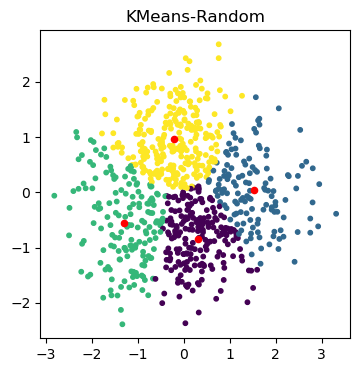

In [3]:
# Perform clustering: K-means (init='random')

kmeans1 = KMeans(init="random", n_clusters=4, n_init=4, random_state=0)
kmeans1.fit(reduced_feats)
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=kmeans1.labels_)
ax.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=20, c="r")
ax.set_title("KMeans-Random")

Text(0.5, 1.0, 'KMeans++')

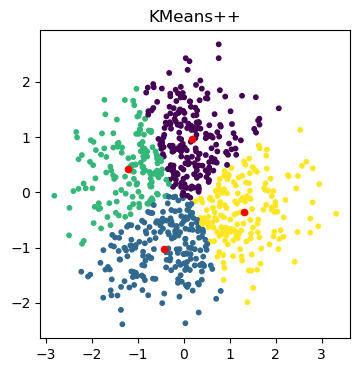

In [4]:
# Perform clustering: K-means (init='k-means++')

kmeans2 = KMeans(init="k-means++", n_clusters=4, n_init=4, random_state=0)
kmeans2.fit(reduced_feats)
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=kmeans2.labels_)
ax.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=20, c="r")
ax.set_title("KMeans++")

Text(0.5, 1.0, 'BisectingKMeans')

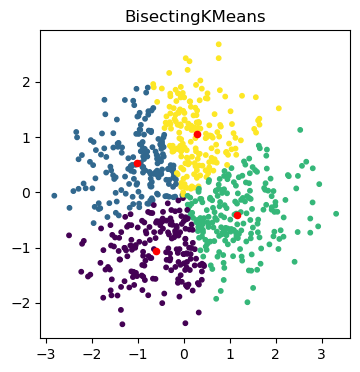

In [5]:
# Perform clustering: Bisecting K-means (init='random')

bisect_means = BisectingKMeans(init="random", n_clusters=4, random_state=0)
bisect_means.fit(reduced_feats)
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=bisect_means.labels_)
ax.scatter(bisect_means.cluster_centers_[:, 0], bisect_means.cluster_centers_[:, 1], s=20, c="r")
ax.set_title("BisectingKMeans")

Text(0.5, 1.0, 'spectral')

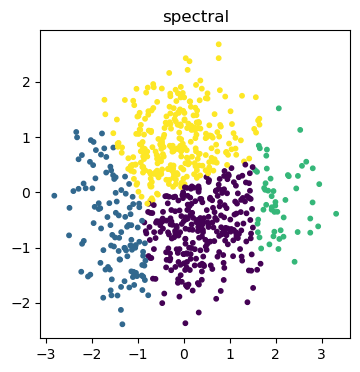

In [6]:
# Perform clustering: Spectral Clustering

spectral = SpectralClustering(n_clusters=4,eigen_solver=None, n_components=None, random_state=None, n_init=10, gamma=1.0, affinity='rbf', n_neighbors=10, eigen_tol='auto', assign_labels='kmeans', degree=3, coef0=1, kernel_params=None, n_jobs=None, verbose=False)
spectral.fit(reduced_feats)
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=spectral.labels_)
ax.set_title("spectral")

Text(0.5, 1.0, 'DBSCAN')

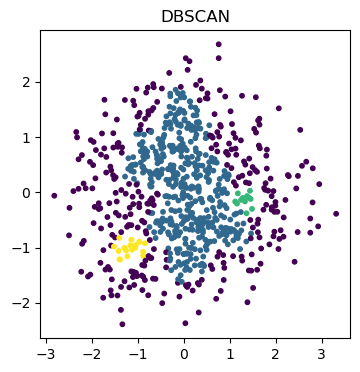

In [7]:
# Perform clustering: DBSCAN Clustering

DBSCAN_clustering=DBSCAN(eps=0.235, min_samples=13, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
DBSCAN_clustering.fit(reduced_feats) 
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=DBSCAN_clustering.labels_)
ax.set_title("DBSCAN")

Text(0.5, 1.0, 'Single Link (MIN)')

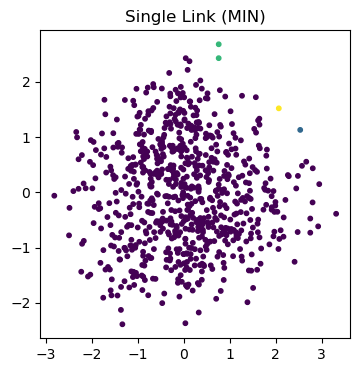

In [8]:
# Perform Agglomerative clustering: Single link (MIN)

aglomerative1=AgglomerativeClustering(n_clusters=4, metric='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='single', distance_threshold=None, compute_distances=False)
aglomerative1.fit(reduced_feats) 
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=aglomerative1.labels_)
ax.set_title("Single Link (MIN)")

Text(0.5, 1.0, 'Complete Link (MAX)')

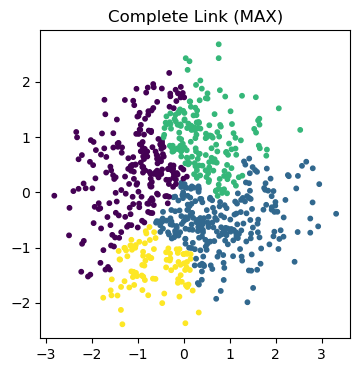

In [9]:
# Perform Agglomerative clustering: Complete link (MAX)

aglomerative2=AgglomerativeClustering(n_clusters=4, metric='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='complete', distance_threshold=None, compute_distances=False)
aglomerative2.fit(reduced_feats) 
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=aglomerative2.labels_)
ax.set_title("Complete Link (MAX)")

Text(0.5, 1.0, 'Group Average')

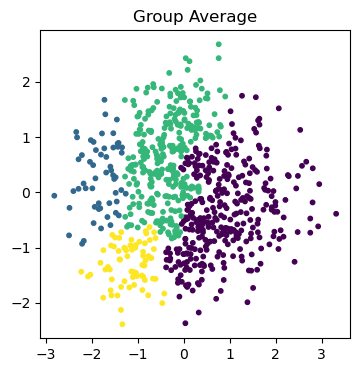

In [10]:
# Perform Agglomerative clustering: Group average

aglomerative3=AgglomerativeClustering(n_clusters=4, metric='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='average', distance_threshold=None, compute_distances=False)
aglomerative3.fit(reduced_feats) 
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=aglomerative3.labels_)
ax.set_title("Group Average")

Text(0.5, 1.0, 'Ward’s method')

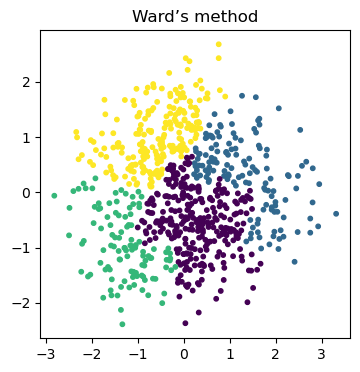

In [11]:
# Perform Agglomerative clustering: Ward's method

aglomerative4=AgglomerativeClustering(n_clusters=4, metric='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)
aglomerative4.fit(reduced_feats) 
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(reduced_feats[:, 0], reduced_feats[:, 1], s=10, c=aglomerative4.labels_)
ax.set_title("Ward’s method")

In [15]:
#Sort the results by Fowlkes Mallows Score and Silhouette Score

results = []

methods=[kmeans1,kmeans2,bisect_means,spectral,DBSCAN_clustering,aglomerative1,
         aglomerative2,aglomerative3,aglomerative4]
method_names = ["KMeans (Random)","KMeans++","Bisecting KMeans","Spectral Clustering", 
                "DBSCAN_clustering","Agglomerative (Single link)","Agglomerative(Complete link)"
                ,"Agglomerative(Group average)","Agglomerative(Ward's method)"]

for method, name in zip(methods, method_names):
    fmi = fowlkes_mallows_score(true_labels, method.labels_)
    silhouette = silhouette_score(reduced_feats, method.labels_)
    results.append({
        'method': name,
        'fmi': fmi,
        'silhouette': silhouette
    })

results_sorted_by_fmi = sorted(results, key=lambda x: x['fmi'], reverse=True)
results_sorted_by_silhouette = sorted(results, key=lambda x: x['silhouette'], reverse=True)

print("Ranking by FMI:")
for result in results_sorted_by_fmi:
    print(f"{result['method']}: {result['fmi']}")
print()
print("Ranking by Silhouette Score:")
for result in results_sorted_by_silhouette:
    print(f"{result['method']}: {result['silhouette']}")


Ranking by FMI:
Agglomerative (Single link): 0.4988585732378548
DBSCAN_clustering: 0.3459296402017857
Agglomerative(Group average): 0.3067780288456689
Spectral Clustering: 0.28842891704046186
Agglomerative(Ward's method): 0.2689491585474061
Agglomerative(Complete link): 0.26730595260109563
KMeans (Random): 0.2603777352099801
KMeans++: 0.254090879385875
Bisecting KMeans: 0.25217969854260086

Ranking by Silhouette Score:
KMeans (Random): 0.35888761281967163
KMeans++: 0.34553763270378113
Spectral Clustering: 0.3363102972507477
Bisecting KMeans: 0.33584246039390564
Agglomerative(Ward's method): 0.3038061261177063
Agglomerative(Group average): 0.264531672000885
Agglomerative(Complete link): 0.2589398920536041
Agglomerative (Single link): 0.22281022369861603
DBSCAN_clustering: -0.15092657506465912
